In [4]:
import re
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer,
    T5ForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    DataCollatorForSeq2Seq,
)


In [5]:

# --- 1. Loading and preprocessing ---
def preprocess_code(code: str) -> str:
    code = re.sub(r'//.*?\n', '', code)
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.S)
    return ' '.join(code.split())

data_df = pd.read_csv('dataset.tsv', sep='\t')
data_df = data_df[~data_df["refactoring_type"].isin(["no_refactoring", "Extract Variable", "Move Method"])]
data_df['code'] = data_df['code'].apply(preprocess_code)


KeyboardInterrupt: 

In [ ]:

# --- 2. Labels ---
unique_labels = sorted(data_df['refactoring_type'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}


In [ ]:

# --- 3. Data split ---
train_df, temp_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df["refactoring_type"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["refactoring_type"])

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))


In [ ]:

# --- 4. Tokenizer & Model ---
model_name = "Salesforce/codet5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

task_prefix = "refactoring classification: "


In [ ]:

# --- 5. Tokenization function ---
def tokenize_batch(batch):
    inputs = [task_prefix + code for code in batch["code"]]

    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=512)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["refactoring_type"], padding="max_length", truncation=True, max_length=10)

    model_inputs["labels"] = labels["input_ids"] 
    return model_inputs





In [ ]:
# --- 6. Dataset prep ---
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df).map(
    tokenize_batch, batched=True, remove_columns=["code", "refactoring_type"]
)

val_dataset = Dataset.from_pandas(val_df).map(
    tokenize_batch, batched=True, remove_columns=["code", "refactoring_type"]
)

test_dataset = Dataset.from_pandas(test_df).map(
    tokenize_batch, batched=True, remove_columns=["code", "refactoring_type"]
)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
print(train_dataset[0]["labels"]) 



In [ ]:
# --- 7. Метрики (по декодированным строкам) ---
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    acc = accuracy_score(decoded_labels, decoded_preds)
    f1 = f1_score(decoded_labels, decoded_preds, average="macro", zero_division=1)
    precision = precision_score(decoded_labels, decoded_preds, average="macro", zero_division=1)
    recall = recall_score(decoded_labels, decoded_preds, average="macro", zero_division=1)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

In [ ]:

# --- 8. Аргументы обучения ---
training_args = Seq2SeqTrainingArguments(
    output_dir="codet5_refactoring_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    num_train_epochs=3,
    load_best_model_at_end=True,
    greater_is_better=True,
    logging_steps=100,
    predict_with_generate=True,
    generation_max_length=10,
)


# --- 9. Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# --- 10. Обучение ---
trainer.train()



NameError: name 'Seq2SeqTrainingArguments' is not defined

In [ ]:
# 🔮 Генерация предсказаний вручную
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

model.eval()
preds = []
true_labels = []

for batch in test_dataloader:
    input_ids = batch["input_ids"].to(model.device)
    attention_mask = batch["attention_mask"].to(model.device)
    labels = batch["labels"]

    with torch.no_grad():
        generated_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=10)

    # Декодируем предсказания и метки
    decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    preds.extend([pred.strip() for pred in decoded_preds])
    true_labels.extend([label.strip() for label in decoded_labels])


In [ ]:
# Метрики
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Метрики
print(f"\n📊 Test Set Metrics:")
print(f"Accuracy:  {accuracy_score(true_labels, preds):.4f}")
print(f"F1 Score:  {f1_score(true_labels, preds, average='macro'):.4f}")
print(f"Precision: {precision_score(true_labels, preds, average='macro', zero_division=1):.4f}")
print(f"Recall:    {recall_score(true_labels, preds, average='macro', zero_division=1):.4f}")



📊 Test Set Metrics:
Accuracy:  0.8126
F1 Score:  0.8092
Precision: 0.8174
Recall:    0.8126


In [ ]:
# Метрики
print(f"\n📊 Test Set Metrics:")
print(f"Accuracy:  {accuracy_score(true_labels, preds):.4f}")
print(f"F1 Score:  {f1_score(true_labels, preds, average='macro'):.4f}")
print(f"Precision: {precision_score(true_labels, preds, average='macro', zero_division=1):.4f}")
print(f"Recall:    {recall_score(true_labels, preds, average='macro', zero_division=1):.4f}")



📊 Test Set Metrics:
Accuracy:  0.8126
F1 Score:  0.8092
Precision: 0.8174
Recall:    0.8126


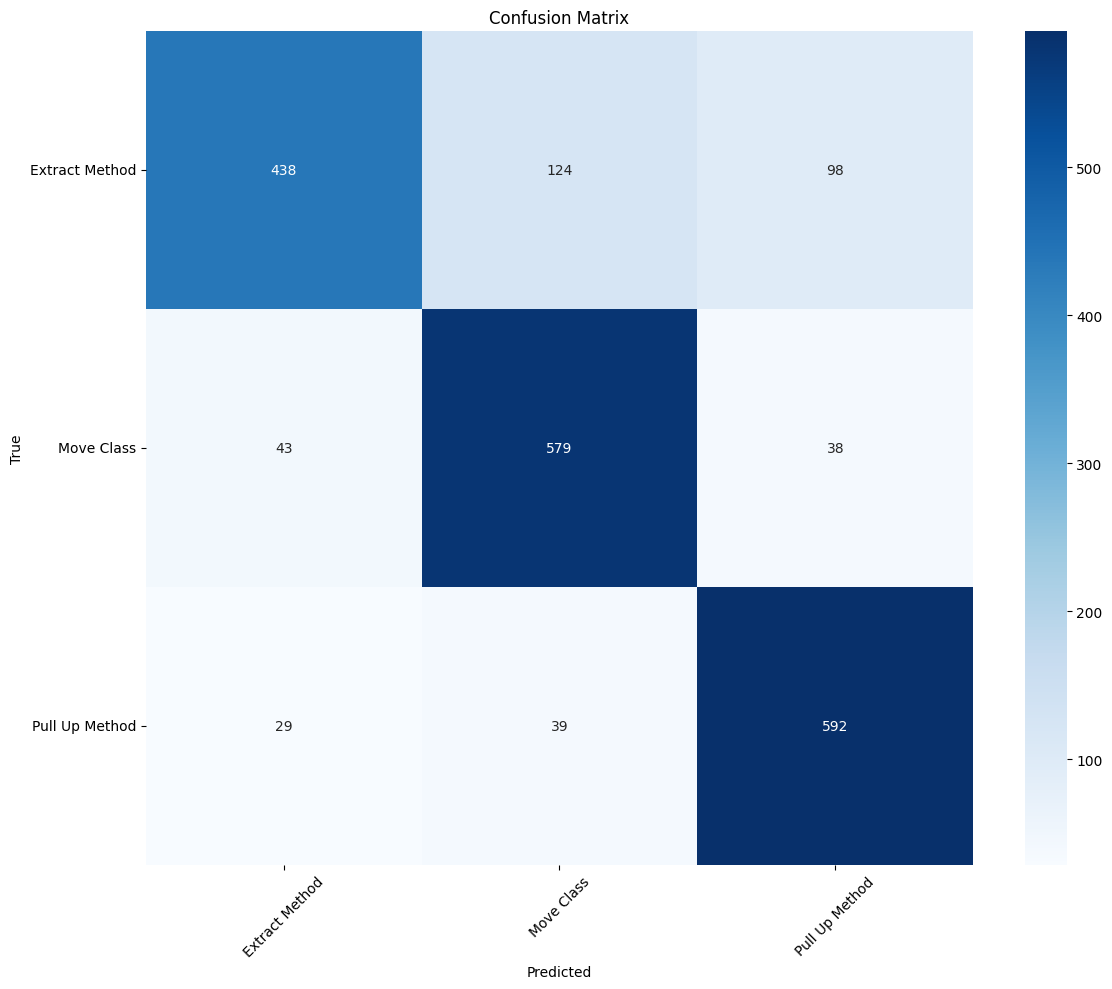

✅ Saved predictions to refactoring_predictions.csv


In [ ]:

# Confusion matrix
cm = confusion_matrix(true_labels, preds, labels=unique_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()